<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

# Preliminaries

In [32]:
import log_reg
import convnet
from imp import reload

from collections import defaultdict
import csv
import operator

import numpy as np
import pandas as pd

import evaluation
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression

%pylab --no-import-all inline
import matplotlib.pyplot as plt
%pylab inline

Populating the interactive namespace from numpy and matplotlib
Populating the interactive namespace from numpy and matplotlib


In [2]:
Y = 10
vocab_min = 3

In [3]:
v_dict = defaultdict(str)
c_dict = defaultdict(str)
with open('../mimicdata/vocab_lookup_' + str(vocab_min) + '.csv', 'r') as vocabfile:
    vr = csv.reader(vocabfile)
    next(vr)
    for row in vr:
        v_dict[int(row[0])] = row[1]

with open('../mimicdata/label_lookup_' + str(Y) + '.csv', 'r') as labelfile:
    lr = csv.reader(labelfile)
    next(lr)
    for row in lr:
        c_dict[int(row[0])] = row[1]

In [4]:
c_dict

defaultdict(str,
            {0: '5849',
             1: '4280',
             2: '4019',
             3: '25000',
             4: '41401',
             5: '2724',
             6: '5990',
             7: '42731',
             8: '53081',
             9: '51881'})

In [5]:
def y_to_codes(y_row):
    return [c_dict[i] for i in range(Y) if y_row[i] == 1]

In [6]:
def x_to_bow(x_row):
    return {v_dict[i]: x_row[i] for i in range(len(x_row)) if x_row[i] > 0}

In [7]:
from torch import autograd, nn, optim, multiprocessing, utils

In [8]:
reload(log_reg)
notefile = '../mimicdata/notes_' + str(Y) + '_train_single.csv'
X_tr_lr, Y_tr_lr = log_reg.construct_X_Y(notefile, Y)

Processing...

In [9]:
X_tr_lr.shape

(20107, 40000)

In [10]:
Y_tr_lr.shape

(20107, 10)

In [11]:
X_tr_lr[0].toarray().sum()

267

In [12]:
devfile = '../mimicdata/notes_' + str(Y) + '_dev_single.csv'
X_dv_lr, Y_dv_lr = log_reg.construct_X_Y(devfile, Y)

Processing.

In [13]:
X_dv_lr.shape

(8971, 40000)

In [14]:
Y_dv_lr.shape

(8971, 10)

In [15]:
Y_dv_lr[-1]

array([0, 0, 1, 0, 0, 0, 1, 0, 0, 1])

In [16]:
testfile = '../mimicdata/notes_' + str(Y) + '_test_single.csv'
X_te_lr, Y_te_lr = log_reg.construct_X_Y(testfile, Y)

Processing.

In [17]:
X_te_lr.shape

(8537, 40000)

In [18]:
Y_te_lr.shape

(8537, 10)

In [18]:
pcts = sorted([np.array(Y_dv_lr[i]).mean() for i in range(Y)])
pcts
#these are the % of instances containing this label for each of the top 10 labels

[0.18409501678285567,
 0.18874257681383941,
 0.2101729925122644,
 0.24141492383165505,
 0.26452362509682414,
 0.2747224373870385,
 0.3187451587916344,
 0.31900335657113349,
 0.32726568551510454,
 0.55499612703330747]

In [19]:
import warnings
warnings.filterwarnings("ignore")

In [20]:
def expand_dims(x):
    return K.expand_dims(x, 1)

def expand_dims_output_shape(input_shape):
    return (1, input_shape[0], input_shape[2], input_shape[1])

In [21]:
def plot_metrics(ax, start, end, steps, y):
    x = np.linspace(start, end, steps)
    if ax.lines:
        for line in ax.lines:
            line.set_xdata(x)
            line.set_ydata(y)
    else:
        ax.plot(x, y)
    fig.canvas.draw()

# LogReg

***** C = 0.01 *****
5 iterations: 
acc,precision,recall,f1
0.280577628443 0.481968618458 0.335075100898 0.36264976926
10 iterations: 
acc,precision,recall,f1
0.287814616056 0.489539309203 0.343114232279 0.370799512852
15 iterations: 
acc,precision,recall,f1
0.290268378001 0.491914157258 0.347602636715 0.374303833745
20 iterations: 
acc,precision,recall,f1
0.291665781982 0.492964101257 0.350022470996 0.37609591204
25 iterations: 
acc,precision,recall,f1
0.292243967776 0.49354560462 0.350924584154 0.376909870372
***** C = 0.1 *****
5 iterations: 
acc,precision,recall,f1
0.269195847997 0.470051117092 0.322860964696 0.350512241199
10 iterations: 
acc,precision,recall,f1
0.282579449124 0.476028844265 0.348553009433 0.36830674744
15 iterations: 
acc,precision,recall,f1
0.291437665989 0.480689364142 0.366208355672 0.380213364089
20 iterations: 
acc,precision,recall,f1
0.291357690477 0.473159545838 0.375613927063 0.382242073932
25 iterations: 
acc,precision,recall,f1
0.292532375043 0.47141092

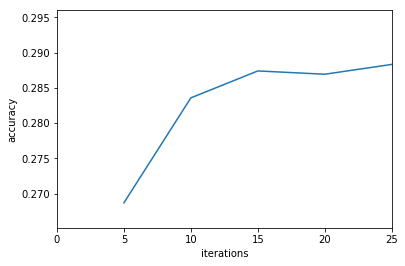

In [22]:
#grid search hyperparams of LR
reload(evaluation)
iter_step = 5
num_steps = 5
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
accs = {C:[] for C in Cs}
precisions = {C:[] for C in Cs}
recalls = {C:[] for C in Cs}
f1s = {C:[] for C in Cs}

fig,ax = plt.subplots(1,1)
ax.set_xlabel("iterations")
ax.set_ylabel("accuracy")
ax.set_xlim(0,iter_step*num_steps)

for C in Cs:
    print("***** C = " + str(C) + " *****")
    for i in range(num_steps):
        print(str((i+1)*iter_step) + " iterations: ")
        reg = OneVsRestClassifier(LogisticRegression(C=C,max_iter=iter_step*(i+1)))
        reg.fit(X_tr_lr, Y_tr_lr)
        yhat = reg.predict(X_dv_lr)
        acc,precision,recall,f1 = evaluation.all_metrics(yhat, Y_dv_lr)
        
        print("acc,precision,recall,f1")
        print(acc,precision,recall,f1)
        
        accs[C].append(acc)
        precisions[C].append(precision)
        recalls[C].append(recall)
        f1s[C].append(f1)
        
        plot_metrics(ax, iter_step, (i+1)*iter_step, i+1, accs[C])

best_C = max([(C, np.mean(f1s[C])) for C in Cs], key=operator.itemgetter(1))[0]

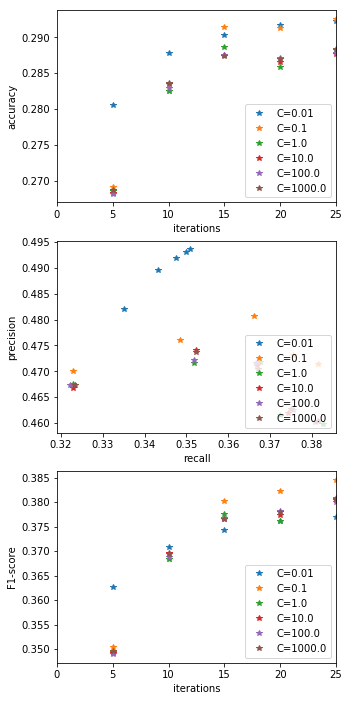

In [27]:
its = np.linspace(iter_step, num_steps*iter_step, num_steps)

fig,ax = plt.subplots(3,1)
fig.set_size_inches(5,12)
ax[0].set_xlabel("iterations")
ax[1].set_xlabel("recall")
ax[2].set_xlabel("iterations")
ax[0].set_ylabel("accuracy")
ax[1].set_ylabel("precision")
ax[2].set_ylabel("F1-score")
ax[0].set_xlim(0,iter_step*num_steps)
# ax[1].set_xlim(0,1)
ax[2].set_xlim(0,iter_step*num_steps)

for C in Cs:
    ax[0].plot(its,accs[C], '*', label="C=" + str(C))
    ax[1].plot(recalls[C], precisions[C], '*', label="C=" + str(C))
    ax[2].plot(its, f1s[C], '*', label="C=" + str(C))
ax[0].legend(loc=4)
ax[1].legend(loc=4)
ax[2].legend(loc=4)

In [29]:
#run for a long time
lr_long = OneVsRestClassifier(LogisticRegression(C=0.1, max_iter=100))
lr_long.fit(X_tr_lr, Y_tr_lr)
yhat_lr = lr_long.predict(X_dv_lr)
acc, precision, recall, f1 = evaluation.all_metrics(yhat_lr, Y_dv_lr)

print("acc,precision,recall,f1")
print(acc,precision,recall,f1)

acc,precision,recall,f1
0.289497286672 0.458535837699 0.392113830632 0.38446477475


In [30]:
yhat_tr = lr_long.predict(X_tr_lr)

In [31]:
acc,precision,recall,f1 = evaluation.all_metrics(yhat_tr, Y_tr_lr)
print("training acc,precision,recall,f1")
print(acc,precision,recall,f1)

training acc,precision,recall,f1
0.653362546093 0.809032627822 0.693217950631 0.721737192533


# ConvNet

In [13]:
import convnet

In [36]:
from keras import backend as K
from keras.layers import Activation, Dense, Dropout, Embedding, Lambda, Reshape
from keras.layers.convolutional import Convolution1D, Convolution2D
from keras.layers.pooling import GlobalMaxPooling1D, MaxPooling1D, GlobalMaxPooling2D
from keras.models import Sequential
from keras.optimizers import Adam

import tensorflow as tf

In [37]:
reload(convnet)
(X_tr_c, Y_tr_c), (X_dv_c, Y_dv_c) = convnet.load_data(Y)

In [20]:
Y_dv_c.shape

(275549, 10)

In [21]:
#pad/crop sequences
from keras.preprocessing import sequence

maxlen = 400
X_tr_c = sequence.pad_sequences(X_tr_c, maxlen=maxlen)
X_dv_c = sequence.pad_sequences(X_dv_c, maxlen=maxlen)

In [22]:
def build_model(Y):
    model = Sequential()
    model.add(Embedding(40000, 50, dropout=0.2, input_length=maxlen))
#     model.add(Lambda(expand_dims, expand_dims_output_shape))
    model.add(Convolution1D(Y, 3, activation='tanh'))
    model.add(GlobalMaxPooling1D())
    model.add(Dense(Y))
    model.add(Dropout(0.2))
    model.add(Activation('sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy')
    return model

In [8]:
#old attempt
# model = Sequential()
# embedding = Embedding(40000, 50, dropout=0.2)
# reshape = Lambda(expand_dims, expand_dims_output_shape)
# conv2d = Convolution2D(Y, 3, 1, activation='tanh', input_shape=(1, None, 1))

In [8]:
# conv2d.get_config()
cnn = build_model(Y)

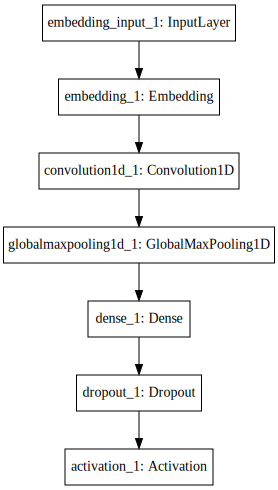

In [9]:
from IPython.display import SVG
from keras.utils.visualize_util import model_to_dot

SVG(model_to_dot(cnn).create(prog='dot', format='svg'))

In [10]:
cnn.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
embedding_1 (Embedding)          (None, 400, 50)       2000000     embedding_input_1[0][0]          
____________________________________________________________________________________________________
convolution1d_1 (Convolution1D)  (None, 398, 10)       1510        embedding_1[0][0]                
____________________________________________________________________________________________________
globalmaxpooling1d_1 (GlobalMaxP (None, 10)            0           convolution1d_1[0][0]            
____________________________________________________________________________________________________
dense_1 (Dense)                  (None, 10)            110         globalmaxpooling1d_1[0][0]       
___________________________________________________________________________________________

In [21]:
X_padded.shape

(20107, 400)

In [22]:
# X_padded = np.reshape(X_padded, (20107, maxlen))
# Y_tr_c = np.reshape(Y_tr_c, (20107,10))

In [23]:
X_tr_c.shape
len([x for x in X_tr_c if len(x) > 667])/float(len(X_tr_c))

0.049833391356244094

In [24]:
Y_tr_c.shape

(20107, 10)

In [25]:
cnn.inputs

[<tf.Tensor 'embedding_input_1:0' shape=(?, 400) dtype=int32>]

In [26]:
cnn.outputs

[<tf.Tensor 'Sigmoid:0' shape=(?, 10) dtype=float32>]

In [35]:
# for note, label in zip(X_tr_c, Y_tr_c):
#     print(note)
#     print(label.shape)
#     label = np.reshape(label, (1,Y))
#     model.train_on_batch(note, label)
hist = cnn.fit(X_padded, Y_tr_c, batch_size=16, nb_epoch=1,validation_data=(X_dv_c, Y_dv_c),verbose=0)

NameError: name 'cnn' is not defined

In [73]:
X_dv_c = sequence.pad_sequences(X_dv_c, maxlen=maxlen)

In [74]:
preds = model.predict(X_dv_c)

In [35]:
preds.shape

(8971, 10)

In [89]:
yhat = np.zeros(preds.shape)

In [90]:
preds[0]

array([ 0.41807741,  0.52856904,  0.40794232,  0.36543503,  0.57675272,
        0.30248693,  0.31626055,  0.25988546,  0.21573617,  0.20210788], dtype=float32)

In [467]:
dumb_yhat = np.array([[1, 1, 1, 1, 1, 0, 0, 0, 0, 0] for _ in range(preds.shape[0])])

In [91]:
yhat[preds>=0.50] = 1
yhat[preds<0.50] = 0

In [95]:
import evaluation
evaluation.all_metrics(yhat, Y_dv_c)

/media/james/Windows8_OS/Users/James/Documents/SCHOOL/MS/research/mimic/src/evaluation.py:15: RuntimeWarning: invalid value encountered in true_divide
  num = intersect_size(yhat, y) / yhat.sum(axis=1)


(0.24472542035801539,
 0.45819864006242306,
 0.27545446261587253,
 0.31902784231956183)

In [96]:
import evaluation
evaluation.all_metrics(np.ones(yhat.shape), Y_dv_c)

(0.27321368855199574, 0.27321368855199574, 1.0, 0.41006704152529178)

In [85]:
preds_tr = model.predict(X_padded)

In [86]:
yhat_tr = np.zeros(preds_tr.shape)

In [87]:
yhat_tr[preds_tr>=0.35] = 1
yhat_tr[preds_tr<0.35] = 0

In [88]:
evaluation.all_metrics(yhat_tr, Y_tr_c)

/media/james/Windows8_OS/Users/James/Documents/SCHOOL/MS/research/mimic/src/evaluation.py:15: RuntimeWarning: invalid value encountered in true_divide
  num = intersect_size(yhat, y) / yhat.sum(axis=1)


(0.40001874889972139,
 0.54690441850385951,
 0.55199024504614547,
 0.50778567431473087)

## Multi-window ConvNet

In [97]:
from keras.layers import Input, merge
from keras.models import Model

model_input = Input(shape=(maxlen,))
embed = Embedding(40000, 50, dropout=0.3)(model_input)

#try multiple conv windows
conv1 = Convolution1D(Y, 3, activation='tanh')(embed)
pool1 = GlobalMaxPooling1D()(conv1)

conv2 = Convolution1D(Y, 4, activation='tanh')(embed)
pool2 = GlobalMaxPooling1D()(conv2)

conv3 = Convolution1D(Y, 5, activation='tanh')(embed)
pool3 = GlobalMaxPooling1D()(conv3)

merged = merge([pool1, pool2, pool3], mode='concat', concat_axis=1)

dense = Dense(Y)(merged)
dropout = Dropout(0.3)(dense)
activation = Activation('sigmoid')(dropout)

cnn_multi = Model(input=model_input, output=activation)

cnn_multi.compile(optimizer='rmsprop', loss='binary_crossentropy')

In [100]:
# model.outputs
cnn_multi.fit(X_padded, Y_tr_c, batch_size=32, nb_epoch=1, validation_data=(X_dv_c, Y_dv_c), verbose=0)

/home/james/anaconda3/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:91: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [101]:
preds_c_m = cnn_multi.predict(X_dv_c)

In [102]:
yhat_c_m = np.zeros(preds.shape)

In [103]:
yhat_c_m[preds_c_m>=0.5] = 1
yhat_c_m[preds_c_m<0.5] = 0

In [104]:
evaluation.all_metrics(yhat_c_m, Y_dv_c)

/media/james/Windows8_OS/Users/James/Documents/SCHOOL/MS/research/mimic/src/evaluation.py:15: RuntimeWarning: invalid value encountered in true_divide
  num = intersect_size(yhat, y) / yhat.sum(axis=1)


(0.12848813549125768,
 0.29495039571954074,
 0.12848813549125768,
 0.16781242203714722)

In [ ]:
preds_tr_c_m = cnn_multi.predict(X_padded)

In [565]:
yhat_tr_c_m = np.zeros(preds_tr_c_m.shape)

In [566]:
yhat_tr[preds_tr_c_m>=0.5] = 1
yhat_tr[preds_tr_c_m<0.5] = 0

In [567]:
evaluation.all_metrics(yhat_tr, Y_tr_c)

(0.98916408326563821,
 0.992273696833053,
 0.99600701721977847,
 0.99299717213773675)

In [34]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# SVM

In [32]:
from sklearn.svm import SVC
iters = [3, 5, 7, 10]
Cs = [1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3]
svms = []
for mx_iter in iters:
    for C in Cs:
        print("C = " + str(C) + ", iters = " + str(mx_iter) + ": ")
        svm = OneVsRestClassifier(SVC(C=C, max_iter=mx_iter))
        svm.fit(X_tr, yy_tr)
        yhat = svm.predict(X_dv)
        acc,precision,recall,f1 = evaluation.all_metrics(yhat, yy_dev)
        print("acc,precision,recall,f1")
        print(acc,precision,recall,f1)
        svms.append(svm)

C = 0.01, iters = 3: 
acc,precision,recall,f1
0.20753594277 0.244468471182 0.609138562043 0.311823809752
C = 0.1, iters = 3: 
acc,precision,recall,f1
0.20753594277 0.244468471182 0.609138562043 0.311823809752
C = 1.0, iters = 3: 
acc,precision,recall,f1
0.20753594277 0.244468471182 0.609138562043 0.311823809752
C = 10.0, iters = 3: 
acc,precision,recall,f1
0.206748285854 0.25461677097 0.589105693056 0.310577218286
C = 100.0, iters = 3: 
acc,precision,recall,f1
0.0880359140816 0.112800923364 0.242436137033 0.13221510305
C = 1000.0, iters = 3: 
acc,precision,recall,f1
0.122095172521 0.189635203423 0.24662826487 0.181343287494
C = 0.01, iters = 5: 
acc,precision,recall,f1
0.206559658031 0.253922864438 0.569262066648 0.308291373023
C = 0.1, iters = 5: 
acc,precision,recall,f1
0.206559658031 0.253922864438 0.569262066648 0.308291373023
C = 1.0, iters = 5: 
acc,precision,recall,f1
0.206559658031 0.253922864438 0.569262066648 0.308291373023
C = 10.0, iters = 5: 
acc,precision,recall,f1
0.2034

KeyboardInterrupt: 